In [1]:
from PINNs import PINN, Geometry, Physics, NetworkTrainer, Visualizer, ProblemDomain
import torch
import matplotlib.pyplot as plt

In [2]:
circle = Geometry.circle(0.2, 0.2, 0.05)
area_big = Geometry.rectangle([0,1.1],[0,0.41])
area = area_big - circle

C:\Users\thamm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


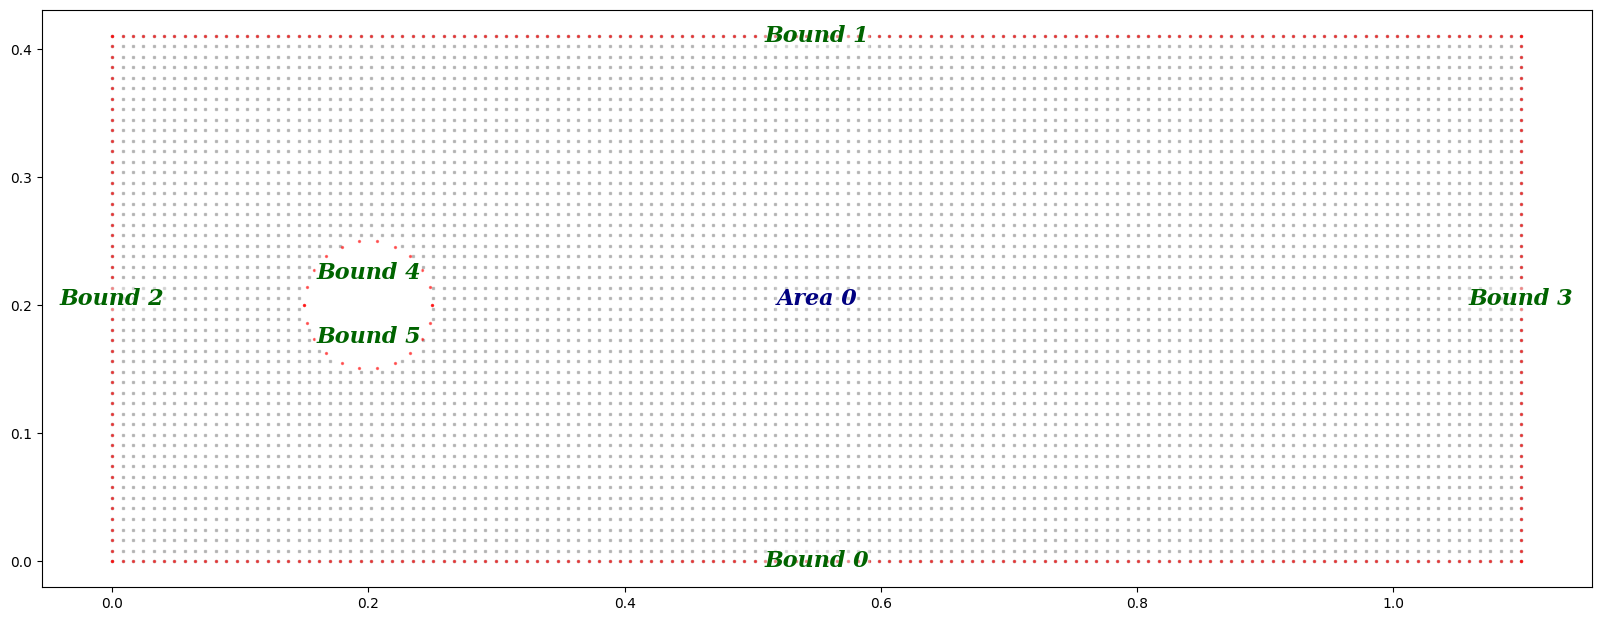

In [3]:
domain = ProblemDomain(area.bound_list + circle.bound_list, [area])
domain.show_setup()

## Define Physics

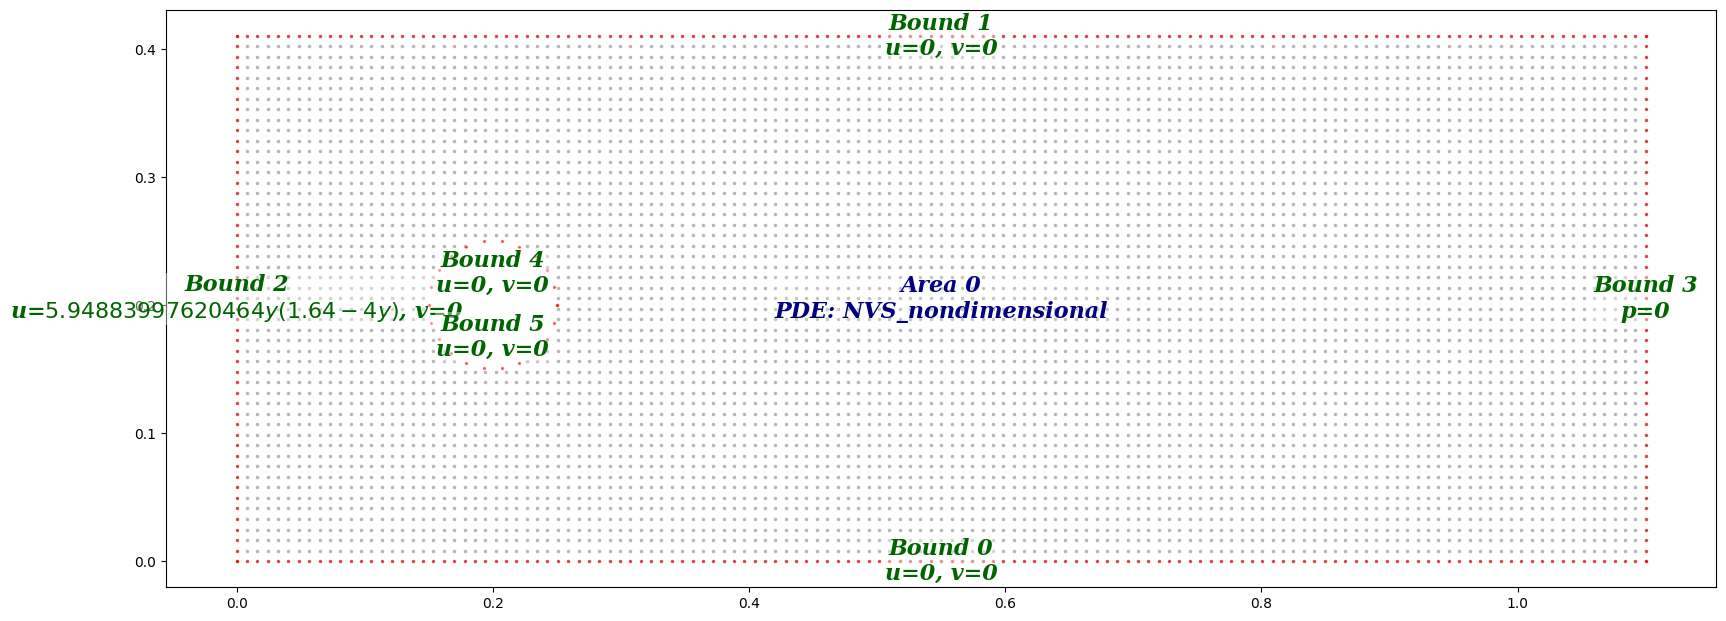

In [4]:
domain.bound_list[0].define_bc({'u':0,'v':0})
domain.bound_list[1].define_bc({'u':0,'v':0})
domain.bound_list[2].define_bc({'u': ['y', lambda x:  4*1*(0.41-x)*x/0.41**2], 'v': 0})
domain.bound_list[3].define_bc({'p':0})
domain.bound_list[4].define_bc({'u': 0, 'v': 0})
domain.bound_list[5].define_bc({'u': 0, 'v': 0})
domain.area_list[0].define_pde(Physics.NVS_nondimensional(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


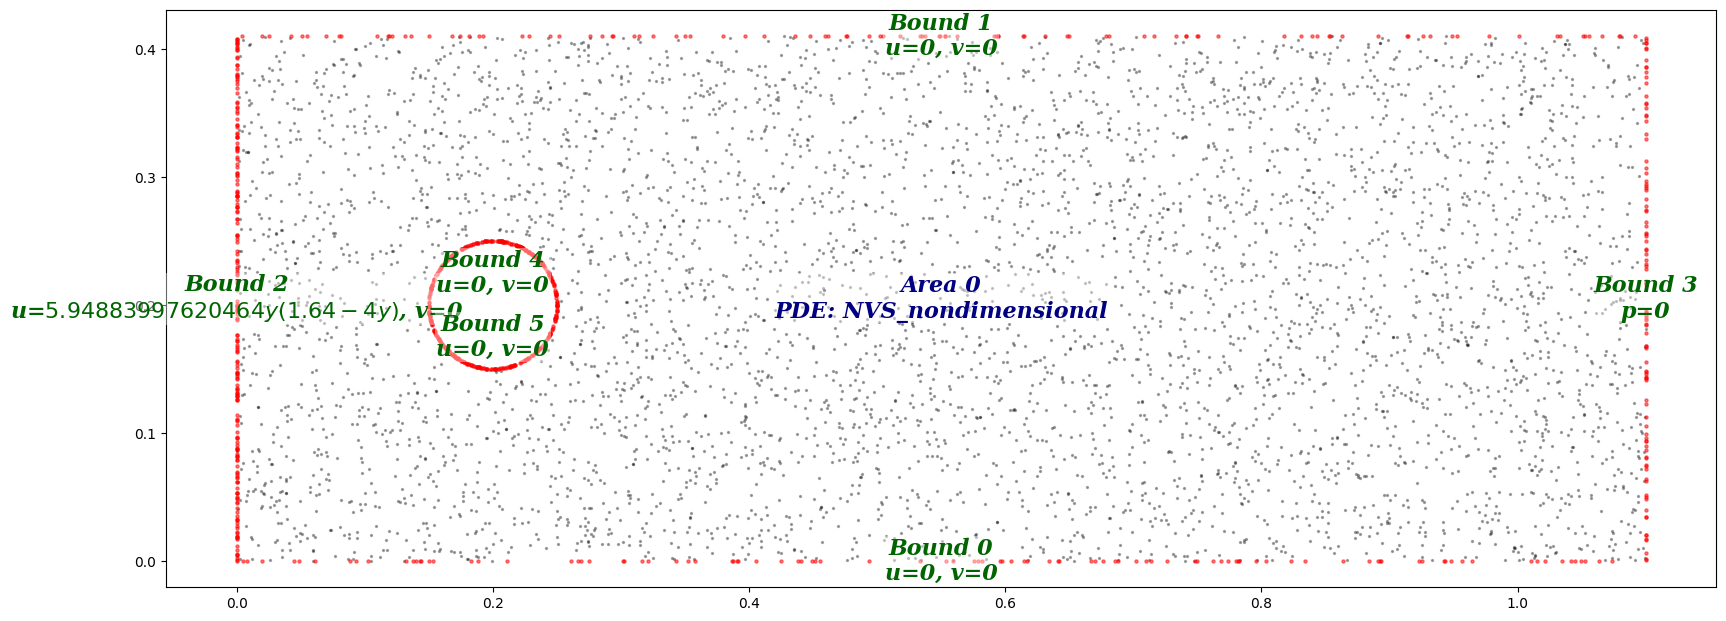

In [5]:
domain.sampling_random_r([100, 100, 200, 100, 200, 200], [5000], device='cuda')
domain.show_coordinates()

In [6]:
model0 = PINN(width=40, length=8)
loss_fn = torch.nn.MSELoss()
n = 0

In [7]:
# Define the loss calculation function
def calc_loss(model):
    global n
    # Re-sample the collocation points
    # if n % 50 == 0 or n == 0:
    #     domain.sampling_random_r([800, 800, 400, 200], [1000], device='cuda')
    n += 1
    if n%1000==0:
        domain.sampling_RAR([40, 40, 160, 40, 80, 80], [2000], model, [200, 200, 400, 200, 400, 400], [20000], device='cuda')
    
    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        if i == 2:
            bc_loss += 2*bc.calc_loss(model, loss_fn)
        else:
            bc_loss += bc.calc_loss(model, loss_fn) #lambda pred, true: ((pred - true)**2/true).mean())

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model, loss_fn)

    # Total Loss
    total_loss = 3*bc_loss + pde_loss

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss}

In [8]:
# Train the model
model1 = NetworkTrainer.train_adam(
    model=model0,
    calc_loss=calc_loss,
    learning_rate=0.0001,
    epochs=10000,
    print_every=100,
    thereshold_loss=0.01,
    device='cuda'
)

epoch 1, total_loss: 2.28260, bc_loss: 0.76087, pde_loss: 0.00000
epoch 101, total_loss: 1.84399, bc_loss: 0.57853, pde_loss: 0.10841
epoch 201, total_loss: 1.58380, bc_loss: 0.47266, pde_loss: 0.16583
epoch 301, total_loss: 1.29980, bc_loss: 0.36942, pde_loss: 0.19154
epoch 401, total_loss: 1.23363, bc_loss: 0.35794, pde_loss: 0.15981
epoch 501, total_loss: 1.18192, bc_loss: 0.33698, pde_loss: 0.17098
epoch 601, total_loss: 1.08960, bc_loss: 0.29496, pde_loss: 0.20473
epoch 701, total_loss: 0.88584, bc_loss: 0.21862, pde_loss: 0.22998
epoch 801, total_loss: 0.73022, bc_loss: 0.17124, pde_loss: 0.21649
epoch 901, total_loss: 0.66400, bc_loss: 0.15533, pde_loss: 0.19802
epoch 1001, total_loss: 1.17901, bc_loss: 0.27933, pde_loss: 0.34101
epoch 1101, total_loss: 1.00585, bc_loss: 0.27176, pde_loss: 0.19056
epoch 1201, total_loss: 0.95273, bc_loss: 0.25565, pde_loss: 0.18579
epoch 1301, total_loss: 0.90045, bc_loss: 0.24009, pde_loss: 0.18017
epoch 1401, total_loss: 0.86274, bc_loss: 0.22

In [9]:
# Train the model
model2 = NetworkTrainer.train_lbfgs(
    model=model1,
    calc_loss=calc_loss,
    epochs=1000,
    print_every=50,
    thereshold_loss=0.002,
    device='cuda'
)

epoch 10001, total_loss: 0.03118, bc_loss: 0.00298, pde_loss: 0.02225
epoch 10051, total_loss: 0.01395, bc_loss: 0.00104, pde_loss: 0.01084
epoch 10101, total_loss: 0.00968, bc_loss: 0.00077, pde_loss: 0.00737
epoch 10151, total_loss: 0.00697, bc_loss: 0.00061, pde_loss: 0.00513
epoch 10201, total_loss: 0.00654, bc_loss: 0.00069, pde_loss: 0.00448
epoch 10251, total_loss: 0.00540, bc_loss: 0.00056, pde_loss: 0.00371
epoch 10301, total_loss: 0.00460, bc_loss: 0.00052, pde_loss: 0.00303
epoch 10351, total_loss: 0.00405, bc_loss: 0.00046, pde_loss: 0.00267
epoch 10401, total_loss: 0.00341, bc_loss: 0.00041, pde_loss: 0.00218
epoch 10451, total_loss: 0.00307, bc_loss: 0.00039, pde_loss: 0.00190
epoch 10501, total_loss: 0.00263, bc_loss: 0.00034, pde_loss: 0.00160
epoch 10551, total_loss: 0.00245, bc_loss: 0.00034, pde_loss: 0.00144
epoch 10601, total_loss: 0.00219, bc_loss: 0.00030, pde_loss: 0.00128
epoch 10651, total_loss: 0.00206, bc_loss: 0.00028, pde_loss: 0.00120
Training stopped at 

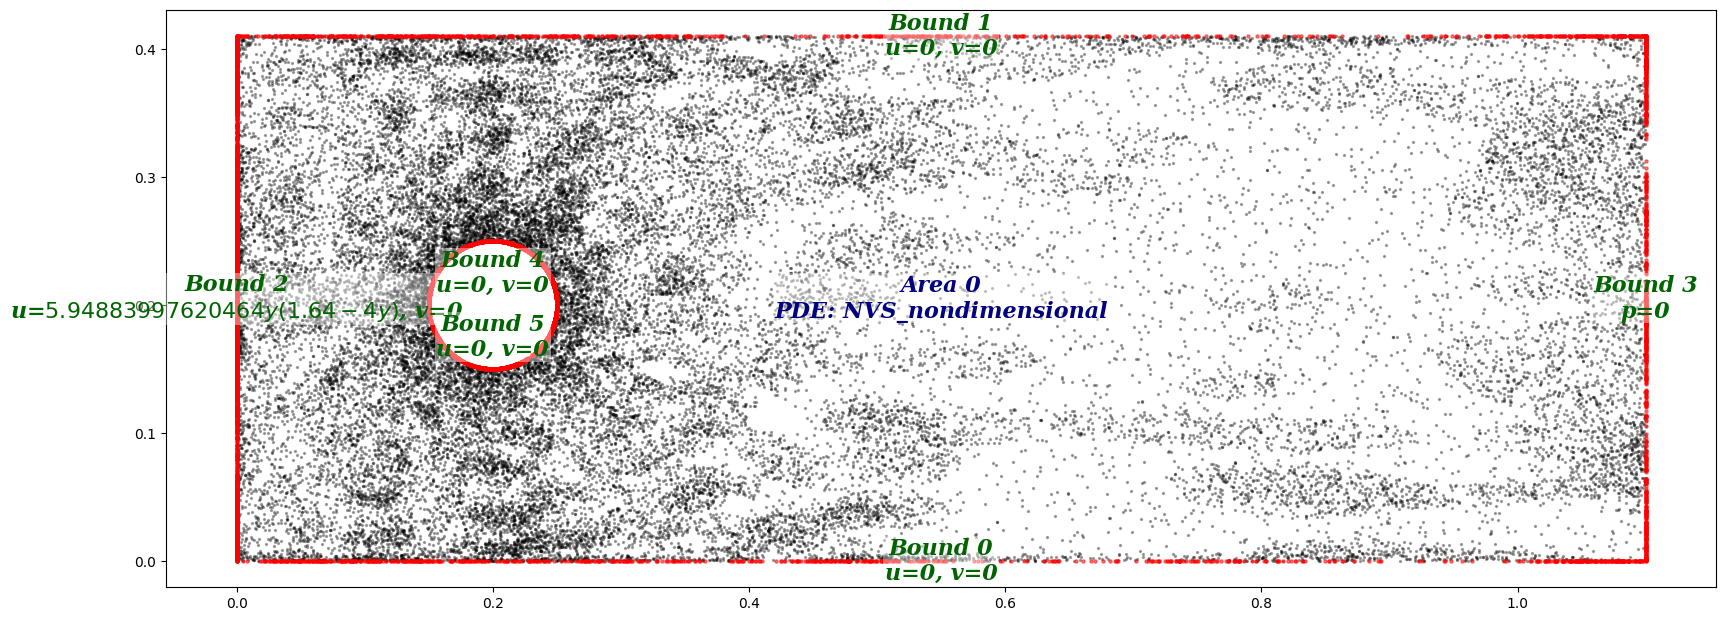

number of bound : 6
        ['0: 780', '1: 780', '2: 2920', '3: 780', '4: 1560', '5: 1560']
        , number of area : 1
        ['0: 38915']


In [10]:
domain.show_coordinates()
print(domain)

In [11]:
# Create visualization object
area_visual = Visualizer(model2, domain.area_list[0])
area_visual.sampling_area([1000,400])
keyword = area_visual.preprocess()

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'u_x', 'v_x', 'p_x', 'u_y', 'v_y', 'p_y', 'u_xx', 'v_xx', 'u_yy', 'v_yy', 'PDE residual', 'total_loss', 'bc_loss', 'pde_loss')


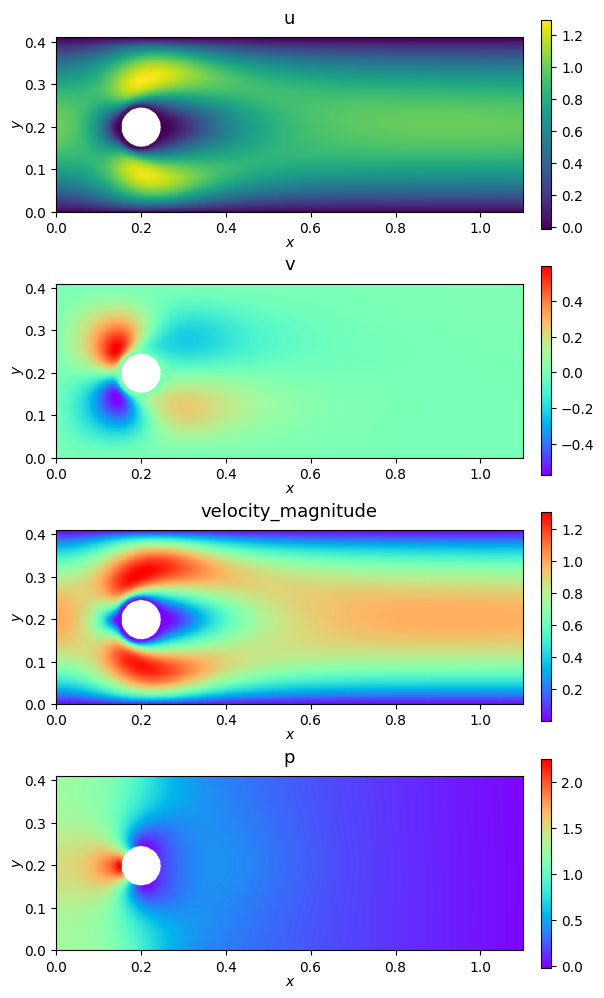

In [12]:
cmap_dict = {
    'u':None,
    'v':'rainbow',
    'velocity_magnitude': 'rainbow',
    'p':'rainbow'
}
colorplot_all = area_visual.plot_data_on_geometry(cmap_dict, s=1)
colorplot_all.savefig('cylinder_flow_steady_all.png')

In [21]:
# Create visualization object
bound_visual = Visualizer(model2, domain.bound_list[3])
bound_visual.sampling_line(100)
bound_visual.preprocess()

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'total_loss', 'bc_loss', 'pde_loss')


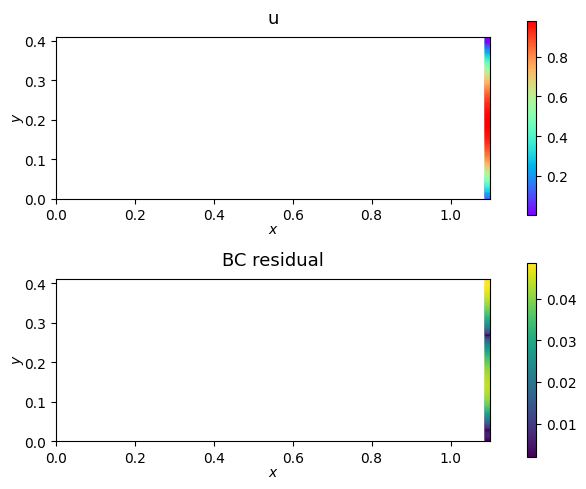

In [22]:
plot = bound_visual.plot_data_on_geometry({'u':'rainbow','BC residual':None}, range_x=[0,1.1], range_y=[0,0.41], s=50)

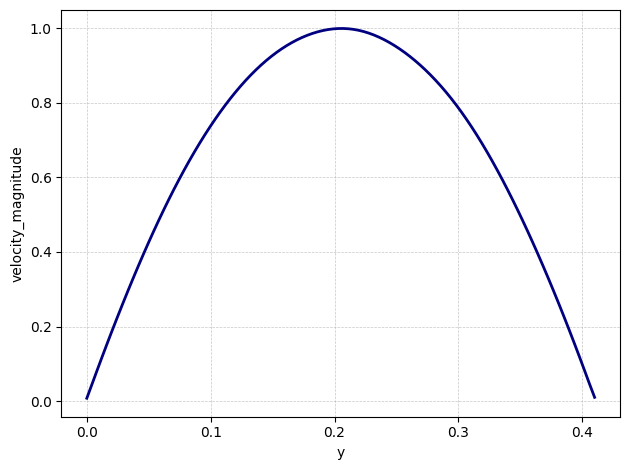

In [15]:
plot = bound_visual.plot_data(['velocity_magnitude'])

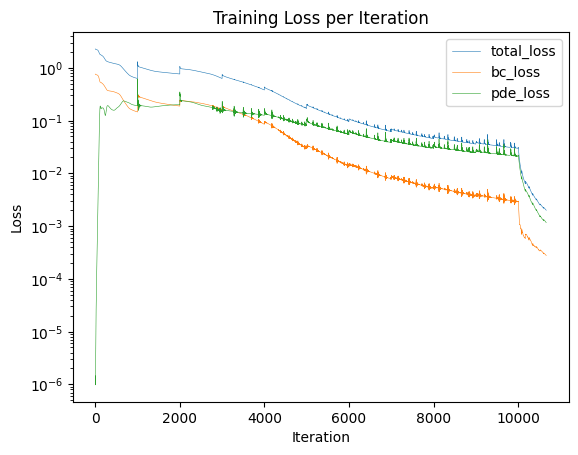

In [16]:
a = bound_visual.plot_loss_evolution(log_scale=True, linewidth=0.4)

In [17]:
import pickle

# Save model with pickle
with open("model.pkl", "wb") as f:
    pickle.dump(model1, f)


In [18]:
# # Load model back
# with open("model.pkl", "rb") as f:
#     model1 = pickle.load(f)

In [19]:
# import numpy as np
# data = np.loadtxt("laminar flow data.txt", delimiter=",", skiprows=1)

NameError: name 'data' is not defined

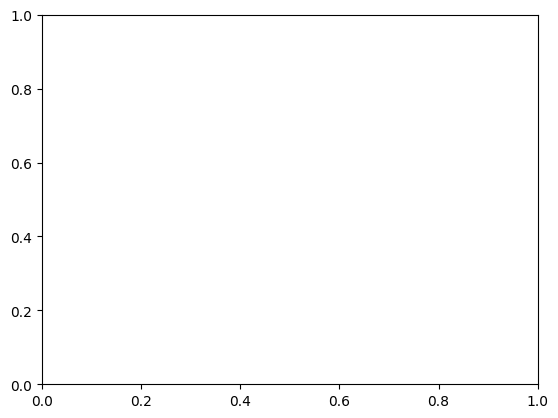

In [20]:
fig, ax = plt.subplots()

X = data[:,1]
Y = data[:,2]
Pressure = data[:,3]
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
Visualizer.colorplot(X, Y, Pressure, ax, s=0.4, cmap='rainbow')
